### Business Understanding

Continuing with our business goal of helping agents succeed in the dynamic real estate market, another angle is to see what features in a home leads to faster sale. There are diverse set of features in a listing and its surroundings. If we extract the common features in the listings with least days on Market, it can help the agents project those features in their listings and also indicate potential hot markets based on geo location. The faster the home sells, agent can close more transactions. 


What features of a listing  helps it sell faster?

Can an agent adopt strategies for a listing to reduce the days on Market?


### Data Understanding

In order to answer the business questions, I am using residential listing dataset containing data for the last 10 years across various California counties with over 125K records and 33 features. The aim is to find the best features where the SaleRate (Target) is higher.

```
SaleoverListPrice	% Sale over list price
ListPrice	
SalePrice	
CountyName	Geographical county
LivingSqFt	Total living square footage
WalkScore	distance to nearby businesses
Subclass	Single Family/Townhome/Condo
LotSize	Approx lot size
Subclass.1	
DaysOnMarket	Number of days listing has been on market
CloseTime	Days before listing went pending
SaleRate	Difference of Max DOM and actual DOM(until Pending)
CloseRate	Difference of Max DOM and actual DOM (until Date of Escrow)
PostalCode	Listing zip code
Age	Current - Year built 
BedsTotal	beds
BathsFull	full baths
Propertyid	unique id
ListingID	unique id
ListingAgentLicenseID	
ListDate	
COEDate	
SaleMonth	
ContractDate	
FilteredAddress	
Latitude	geo location
Longitude	geo location
PhotoCount	Number of listing photos
VirtualTour	
OpenhouseHours	Number of open house hours
OpenhouseCt	Number of open house
tourCt	Number of tours
ElementarySchoolRating	
HighSchoolRating	
```

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector,RFE
from scipy.special import exp10
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Let's first look at the full listing dataset
# import dataset
df = pd.read_excel('data/listingdata.xlsx')


In [3]:
df.head()

,SaleoverListPrice,ListPrice,SalePrice,CountyName,LivingSqFt,WalkScore,Subclass,LotSize,Subclass.1,DaysOnMarket,...,FilteredAddress,Latitude,Longitude,PhotoCount,VirtualTour,OpenhouseHours,OpenhouseCt,tourCt,ElementarySchoolRating,HighSchoolRating
0,1.55,284900,442050.0,San Benito,2071,0,101,87120.0,101,11,...,7750 Lovers LN,36.957222,-121.430538,9,0,0,0,0,5,5
1,1.04,938000,972000.0,San Mateo,1430,73,101,3570.0,101,51,...,691 South Mayfair AVE,37.699968,-122.488096,12,0,23,9,0,5,5
2,0.99,499999,495000.0,Monterey,994,65,101,3750.0,101,12,...,1448 Mingo AVE,36.611745,-121.834122,22,0,6,2,0,5,5
3,1.20,442000,530000.0,Monterey,1152,0,101,95832.0,101,59,...,2929 San Juan RD,36.855276,-121.634515,2,0,0,0,0,5,5
4,1.04,788000,820000.0,Santa Clara,1380,50,102,35103.0,102,1,...,1777 Lafayette ST 213,37.357146,-121.946273,1,0,0,0,0,5,5


## Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125984 entries, 0 to 125983
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   SaleoverListPrice       125979 non-null  float64       
 1   ListPrice               125984 non-null  int64         
 2   SalePrice               125979 non-null  float64       
 3   CountyName              125984 non-null  object        
 4   LivingSqFt              125984 non-null  int64         
 5   WalkScore               125984 non-null  int64         
 6   Subclass                125984 non-null  int64         
 7   LotSize                 125984 non-null  float64       
 8   Subclass.1              125984 non-null  int64         
 9   DaysOnMarket            125984 non-null  int64         
 10  CloseTime               125984 non-null  int64         
 11  SaleRate                125984 non-null  int64         
 12  CloseRate               125984

Text(0, 0.5, 'null count')

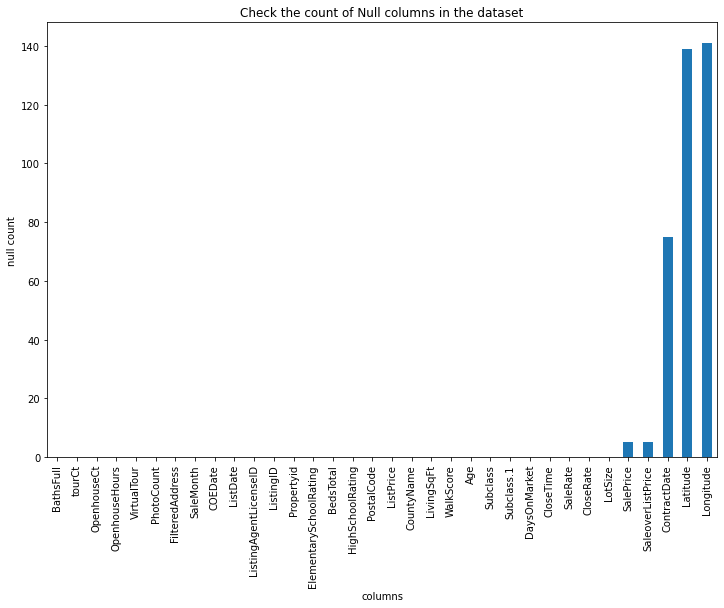

In [5]:
plt.figure(figsize=(12,8))
df.isnull().sum()
nullplot=df.isnull().sum().sort_values().plot(kind = 'bar',title="Check the count of Null columns in the dataset")
nullplot.set_xlabel("columns")
nullplot.set_ylabel("null count")

Since there are not many null columns, we can drop them. 


Text(0, 0.5, 'SaleRate')

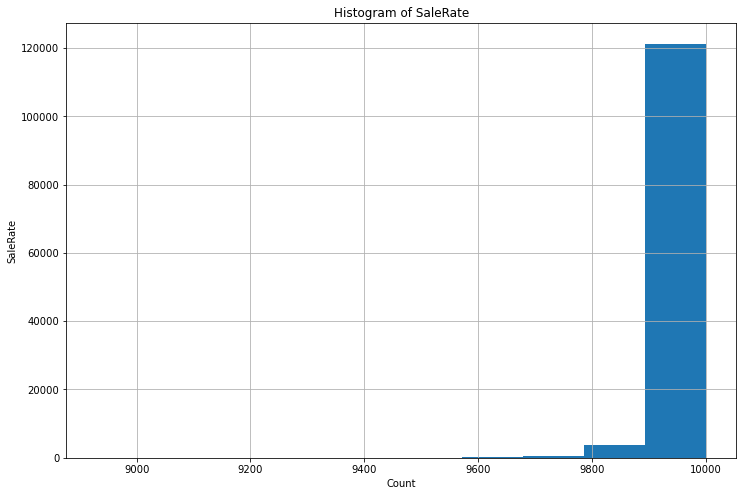

In [6]:
#Let's look at the distribition of the Target column SaleRate
plt.figure(figsize=(12,8))
df["SaleRate"].hist()

plt.title('Histogram of SaleRate')
plt.xlabel('Count')
plt.ylabel('SaleRate')

Skewness: -5.623216


<Figure size 864x576 with 0 Axes>

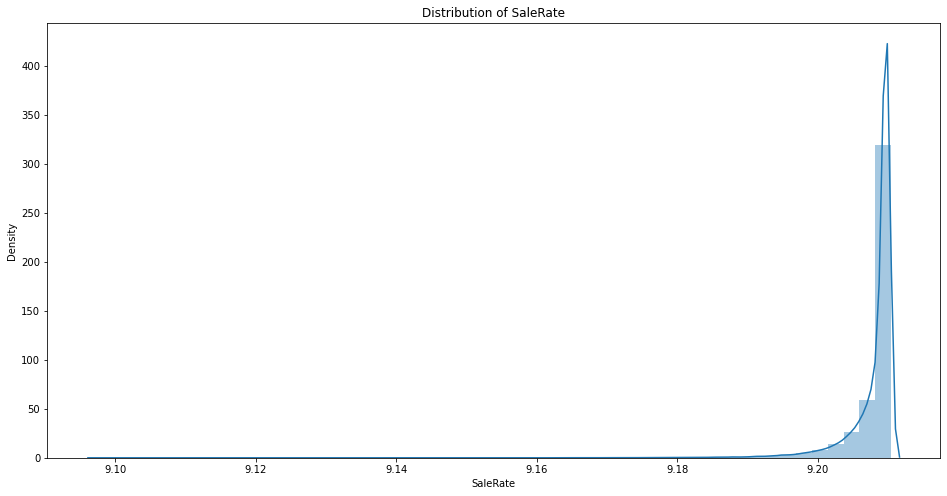

In [10]:
plt.figure(figsize=(12,8))
plt.figure(figsize=(16,8))
sns.distplot(np.log1p(df["SaleRate"]))

plt.title('Distribution of SaleRate')
print("Skewness: %f" % np.log1p(df["SaleRate"]).skew())

Need to convert the target column to logarithmic to achieve normal distribution

<AxesSubplot:title={'center':'SaleRate in various SubClasses of Property'}, xlabel='Subclass', ylabel='SaleRate'>

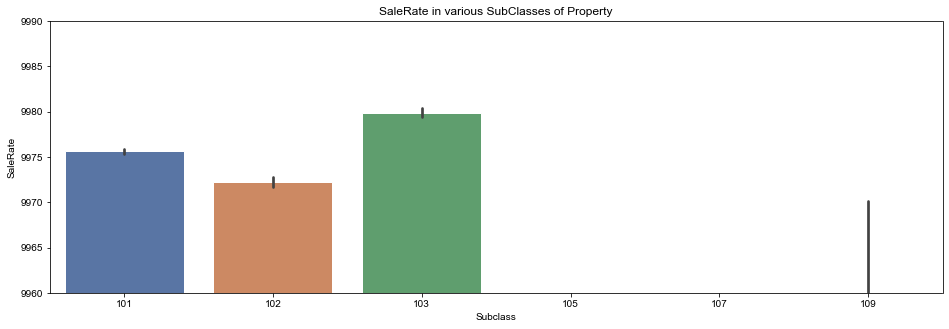

In [8]:
plt.figure(figsize=(16,5))
plt.title('SaleRate in various SubClasses of Property')
plt.ylim(9960, 9990)
sns.set(rc={'axes.grid': True,'xtick.labelsize':16})
sns.barplot(df['Subclass'],df["SaleRate"])

<AxesSubplot:title={'center':'Sales by County'}, xlabel='CountyName', ylabel='SaleRate'>

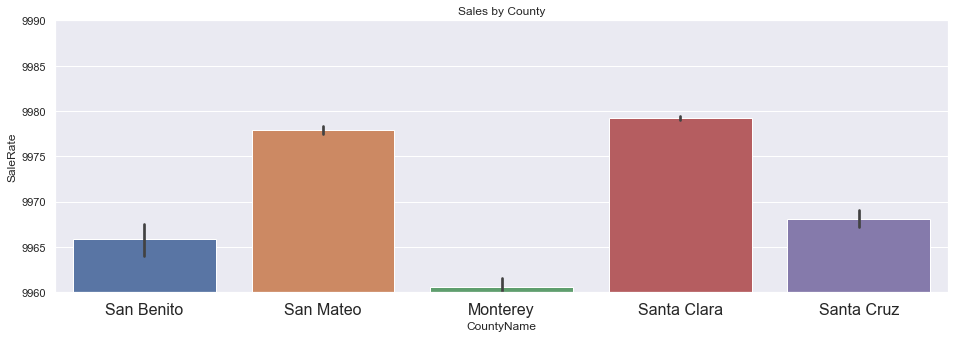

In [9]:
plt.figure(figsize=(16,5))
plt.title('Sales by County')
plt.ylim(9960, 9990)
sns.set(rc={'axes.grid': True,'xtick.labelsize':16})
sns.barplot(df['CountyName'],df["SaleRate"])

<AxesSubplot:title={'center':'Sale by Month'}, xlabel='SaleMonth', ylabel='SaleRate'>

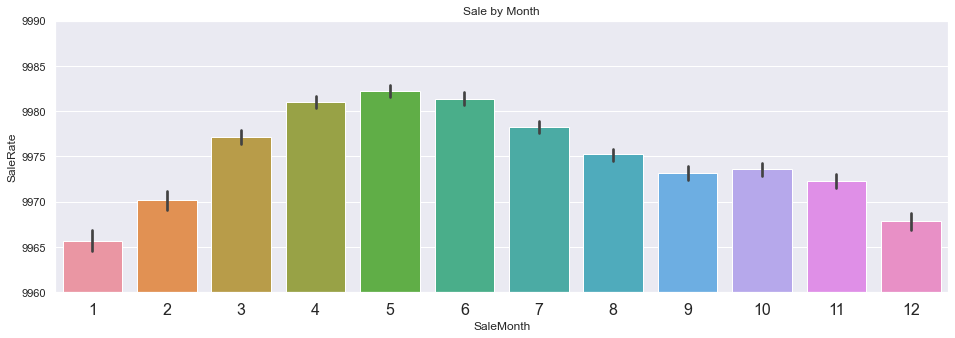

In [10]:
plt.figure(figsize=(16,5))
plt.title('Sale by Month')
plt.ylim(9960, 9990)
sns.set(rc={'axes.grid': True,'xtick.labelsize':16})
sns.barplot(df['SaleMonth'],df["SaleRate"])

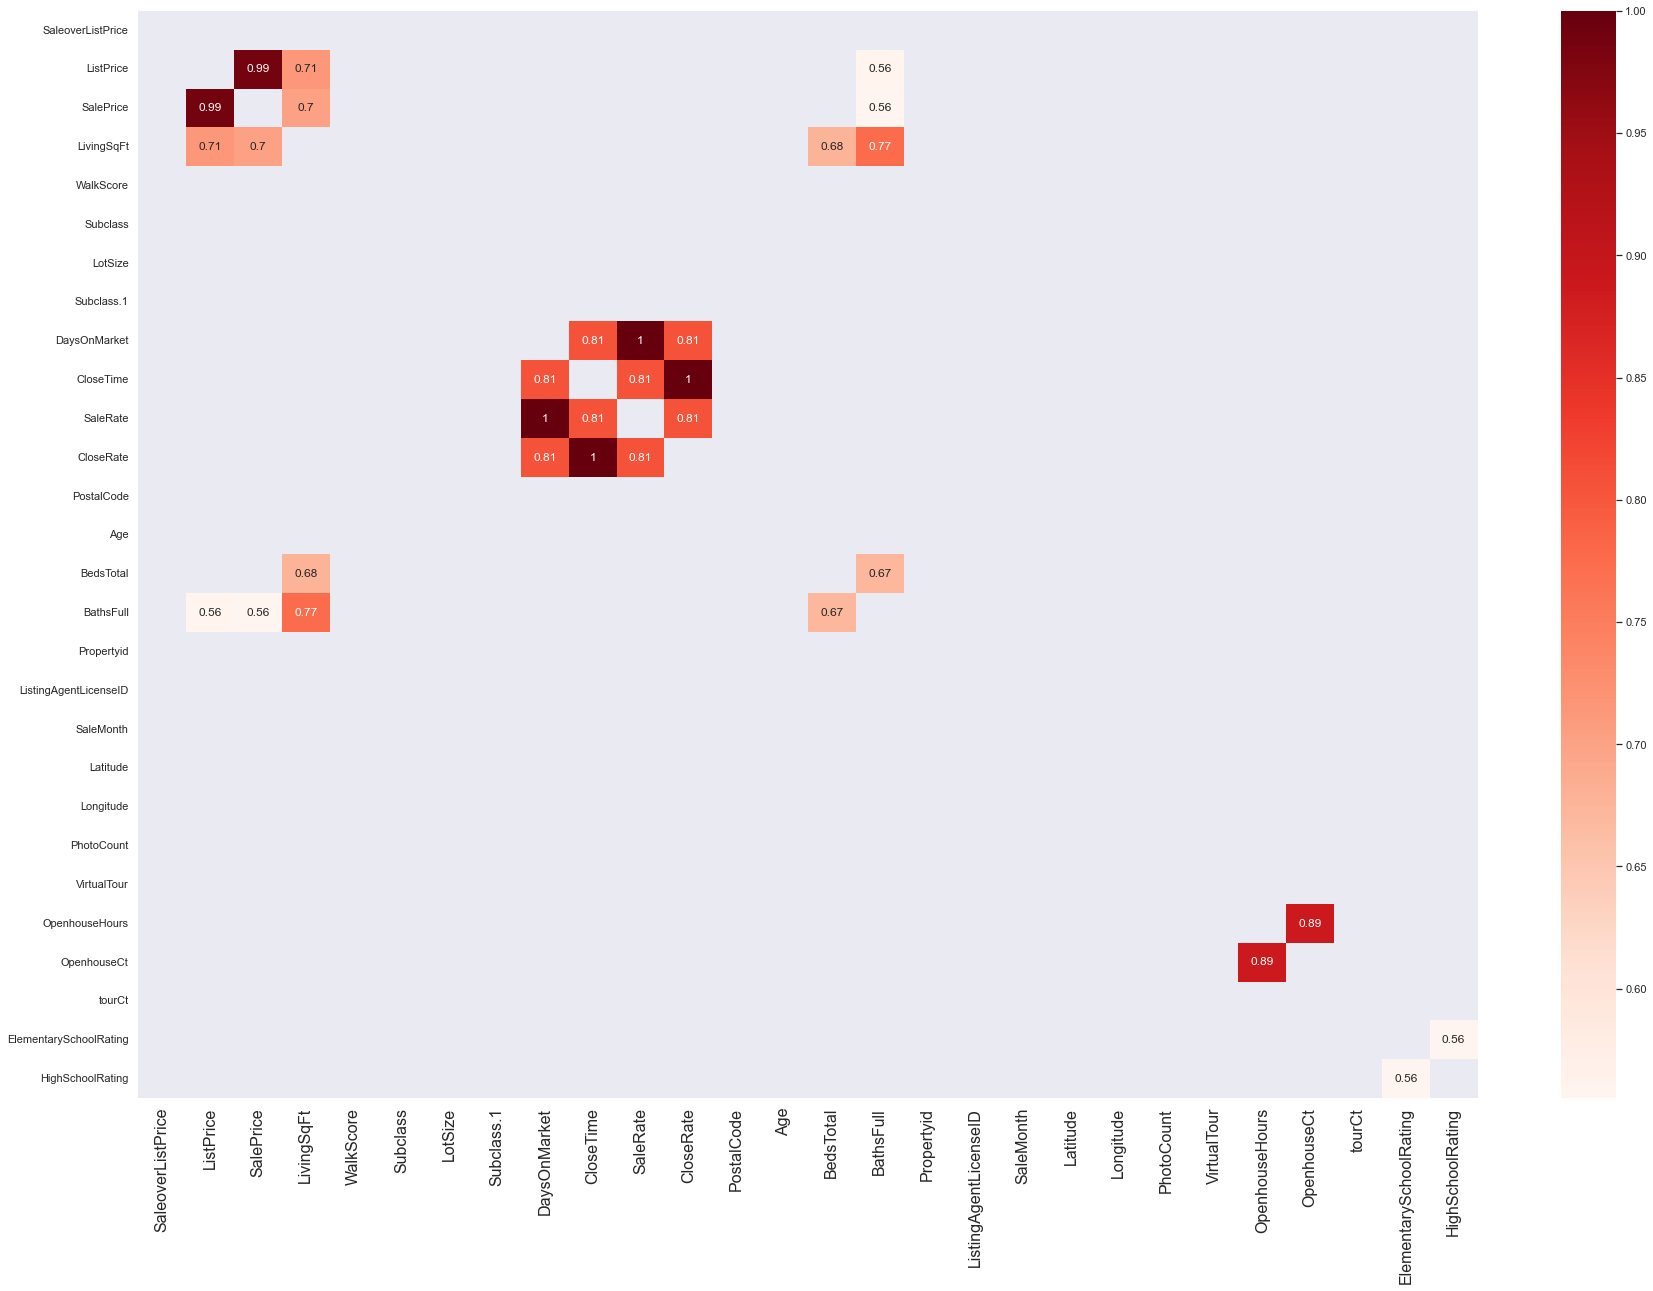

In [14]:
# create correlation matrix with abs values
corr_matrix = df.corr().abs()
threshold = 0.5
filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)] 
plt.figure(figsize=(30,20))
sns.heatmap(filtered_corr_df, annot=True, cmap="Reds")
plt.show()

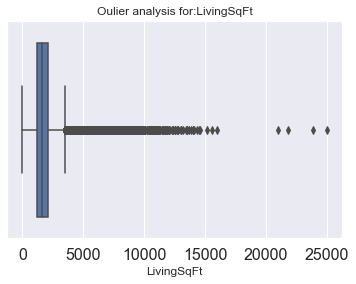

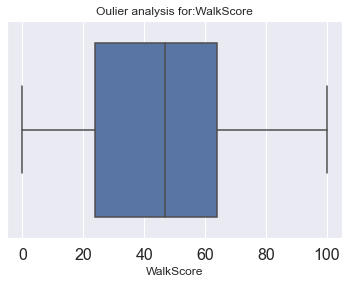

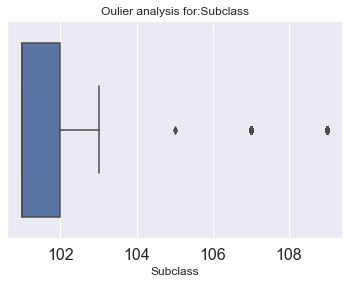

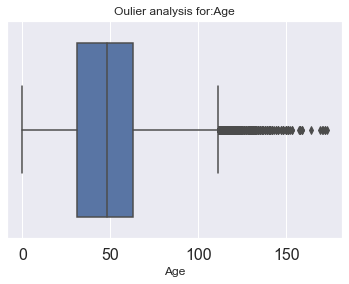

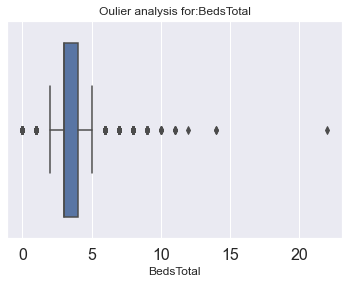

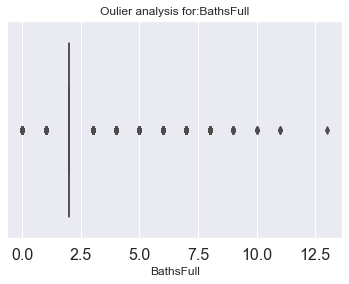

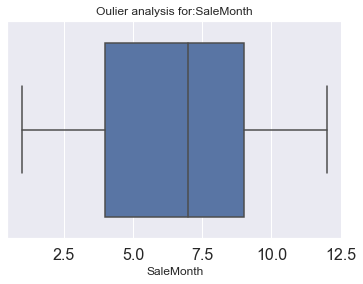

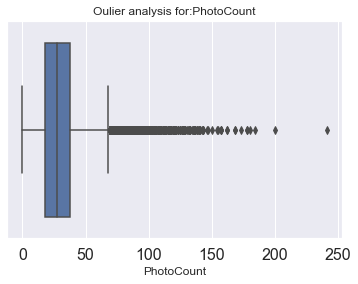

In [16]:
# integer_columns=df.select_dtypes(include=['int64','float64']).columns.tolist()
integer_columns=['LivingSqFt','WalkScore','Subclass','Age','BedsTotal','BathsFull','SaleMonth','PhotoCount']
integer_columns

for i in integer_columns:
    plt.figure()
    sns.boxplot(x=df[i])
    plt.title('Oulier analysis for:'+i)

### EDA Findings

The target column SaleRate need to be transformed for a normal distribution.

Most listings are distributed among 3 majot subclasses.

The SaleRate is higher in the hot months of April, May, and June.

The SaleRate seems to higher in Santa Clara and San Mateo counties.

There are a lot of outliers in multiple features and need to be removed before modeling.

The heatmap does not really indicate strong coorelation between features



## Data Preparation

Remove all the outliers based on the plots above

Transform the target column using log

Drop closely correlated and id columns as they will not add value to final modeling


In [80]:
df_sc = df[(df["Subclass"] < 104) & (df['LivingSqFt']<10000) & (df['BedsTotal']<7) & (df['BathsFull']<4) & (df['PhotoCount']<70)]

In [81]:
df_sc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117228 entries, 0 to 125983
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   SaleoverListPrice       117227 non-null  float64       
 1   ListPrice               117228 non-null  int64         
 2   SalePrice               117227 non-null  float64       
 3   CountyName              117228 non-null  object        
 4   LivingSqFt              117228 non-null  int64         
 5   WalkScore               117228 non-null  int64         
 6   Subclass                117228 non-null  int64         
 7   LotSize                 117228 non-null  float64       
 8   Subclass.1              117228 non-null  int64         
 9   DaysOnMarket            117228 non-null  int64         
 10  CloseTime               117228 non-null  int64         
 11  SaleRate                117228 non-null  int64         
 12  CloseRate               117228

In [82]:
 df_scfinal['SaleRate'] = np.log10(df_scfinal['SaleRate'])

In [83]:
df_scfinal=df_sc.drop(['DaysOnMarket','CloseTime','Propertyid','ListingAgentLicenseID','FilteredAddress','ListingID'
                     ,'COEDate','ContractDate','ListDate','SalePrice','CloseRate','Subclass.1'], axis=1).dropna()
#data_modelling=data_clean.dropna()

## Modeling

After preparing the data, we split the final dataset into train and test sets with 70:30 split

Encode the categorical colum using one hot encoding and StandardScaler for numerical columns

Calculate the baseline Mean Absolute Error

Run various Regression Models and calculate the MAE and Accuracy score


In [84]:
X1 = df_scfinal.drop('SaleRate', axis = 1)
y1 = df_scfinal['SaleRate']
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=22)

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81972 entries, 63511 to 117471
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SaleoverListPrice       81972 non-null  float64
 1   ListPrice               81972 non-null  int64  
 2   CountyName              81972 non-null  object 
 3   LivingSqFt              81972 non-null  int64  
 4   WalkScore               81972 non-null  int64  
 5   Subclass                81972 non-null  int64  
 6   LotSize                 81972 non-null  float64
 7   PostalCode              81972 non-null  int64  
 8   Age                     81972 non-null  int64  
 9   BedsTotal               81972 non-null  int64  
 10  BathsFull               81972 non-null  int64  
 11  SaleMonth               81972 non-null  int64  
 12  Latitude                81972 non-null  float64
 13  Longitude               81972 non-null  float64
 14  PhotoCount              81972 non

In [86]:
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mae_baseline_train = median_absolute_error(baseline_train, y_train)
mae_baseline_test = median_absolute_error(baseline_test, y_test)
print(mae_baseline_train,mae_baseline_test)

15.333089347581335 15.113770921097966


In [87]:
ohe_cols=['CountyName']
num_cols=['SaleoverListPrice', 'ListPrice', 'LivingSqFt', 'WalkScore', 'LotSize', 'Subclass', 'PostalCode', 'Age',
 'BedsTotal',
 'BathsFull',
 'SaleMonth',
 'Latitude',
 'Longitude',
 'PhotoCount',
 'VirtualTour',
 'OpenhouseHours',
 'OpenhouseCt',
 'tourCt',
 'ElementarySchoolRating',
 'HighSchoolRating']

ordinal_ohe_transformer = make_column_transformer(
    (OneHotEncoder(drop="if_binary",handle_unknown='ignore'), ohe_cols),   

                        (StandardScaler(), num_cols),                          
                                          remainder='passthrough')

In [58]:
num_cols

['SaleoverListPrice',
 'ListPrice',
 'LivingSqFt',
 'WalkScore',
 'Subclass',
 'PostalCode',
 'Age',
 'BedsTotal',
 'BathsFull',
 'SaleMonth',
 'Latitude',
 'Longitude',
 'PhotoCount',
 'VirtualTour',
 'OpenhouseHours',
 'OpenhouseCt',
 'tourCt',
 'ElementarySchoolRating',
 'HighSchoolRating']

In [88]:
mresult=[]
pipe1 = Pipeline([('transformer', ordinal_ohe_transformer), ('linreg', LinearRegression())])
pipe1.fit(X_train, y_train)
p1 = pipe1.predict(X_train)
p2 = pipe1.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe1.score(X_test,y_test)}')
mresult.append(['Linear', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe1.score(X_test,y_test)])

Train MAE: 11.283760070800781
Test MAE: 11.270774841308594
Accuracy Score: 0.2853016005608022


In [89]:
pipe2 = make_pipeline(ordinal_ohe_transformer, TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=exp10
    ))
pipe2.fit(X_train, y_train)
    #fit on train
p1 = pipe2.predict(X_train)
p2 = pipe2.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe2.score(X_test,y_test)}')
mresult.append(['TTR_Ridge', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe2.score(X_test,y_test)])

Train MAE: 11.332113871680122
Test MAE: 11.316379151519868
Accuracy Score: 0.28540405149445625


In [90]:
pipe3 = Pipeline([('transformer', ordinal_ohe_transformer), ('DT', DecisionTreeRegressor())])
pipe3.fit(X_train, y_train)
    #fit on train
p1 = pipe3.predict(X_train)
p2 = pipe3.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe3.score(X_test,y_test)}')
mresult.append(['DecisionTree', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe3.score(X_test,y_test)])

Train MAE: 0.0
Test MAE: 6.0
Accuracy Score: -0.242519457493503


In [91]:
pipe4 = Pipeline([('transformer', ordinal_ohe_transformer), ('ridgereg', Ridge())])
pipe4.fit(X_train, y_train)
    #fit on train
p1 = pipe4.predict(X_train)
p2 = pipe4.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe4.score(X_test,y_test)}')
mresult.append(['Ridge', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe4.score(X_test,y_test)])

Train MAE: 11.286942072130842
Test MAE: 11.27158008133756
Accuracy Score: 0.285299566410421


In [92]:
pipe5 = make_pipeline(ordinal_ohe_transformer, TransformedTargetRegressor( regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)))
pipe5.fit(X_train, y_train)
    #fit on train
p1 = pipe5.predict(X_train)
p2 = pipe5.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe5.score(X_test,y_test)}')
mresult.append(['TTR_RandomForest', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe5.score(X_test,y_test)])

Train MAE: 2.139999999999418
Test MAE: 5.920000000000073
Accuracy Score: 0.3768934154121506


### Permutation Importance

In [93]:
scoring = ['r2']
r_multi = permutation_importance(
    pipe5, X_test, y_test, n_repeats=30, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {X_test.columns[i]:<8}"
                  f"  {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    OpenhouseCt  0.386 +/- 0.007
    SaleoverListPrice  0.192 +/- 0.008
    ListPrice  0.082 +/- 0.004
    Latitude  0.069 +/- 0.004
    LivingSqFt  0.054 +/- 0.003
    OpenhouseHours  0.042 +/- 0.002
    Age       0.027 +/- 0.005
    tourCt    0.025 +/- 0.002
    LotSize   0.024 +/- 0.002
    Longitude  0.020 +/- 0.001
    SaleMonth  0.017 +/- 0.002
    WalkScore  0.016 +/- 0.004
    PhotoCount  0.010 +/- 0.002
    PostalCode  0.008 +/- 0.002
    ElementarySchoolRating  0.004 +/- 0.001
    BedsTotal  0.004 +/- 0.001
    Subclass  0.003 +/- 0.001
    HighSchoolRating  0.002 +/- 0.001
    VirtualTour  0.002 +/- 0.000
    BathsFull  0.001 +/- 0.000
    CountyName  0.001 +/- 0.000


### Improving Model using GridSearch

In [57]:
param_dict = {'ridge__regressor__alpha': np.logspace(0, 10, 20)}
pipev2 = Pipeline([( 'ridge', TransformedTargetRegressor(regressor=Ridge(), func=np.log10, inverse_func=exp10)) ])
grid = GridSearchCV(estimator=pipev2, param_grid=param_dict)
grid_2 = make_pipeline(ordinal_ohe_transformer, grid)
grid_2.fit(X_train, y_train)
train_preds = grid_2.predict(X_train)
test_preds = grid_2.predict(X_test)
model_2_train_mse = median_absolute_error(y_train, train_preds)
model_2_test_mse = median_absolute_error(y_test, test_preds)
print(f'Train MAE: {model_2_train_mse}')
print(f'Test MAE: {model_2_test_mse}')
print(f'Best Alpha: {grid.best_params_}')

Train MAE: 11.331949952880677
Test MAE: 11.31634052984009
Best Alpha: {'ridge__regressor__alpha': 1.0}


In [71]:
pipe6 = Pipeline([('transformer', ordinal_ohe_transformer), ('ridgereg', Ridge(alpha=1.0))])
pipe6.fit(X_train, y_train)
    #fit on train
p1 = pipe6.predict(X_train)
p2 = pipe6.predict(X_test)
print(f'Train MAE: {median_absolute_error(y_train, p1)}')
print(f'Test MAE: {median_absolute_error(y_test, p2)}')
print(f'Accuracy Score: {pipe4.score(X_test,y_test)}')
mresult.append(['Grid_Ridge_Alpha1', median_absolute_error(y_train, p1),median_absolute_error(y_test, p2),pipe6.score(X_test,y_test)])

Train MAE: 11.286941852355994
Test MAE: 11.27158123009849
Accuracy Score: 0.2852995651969359


In [76]:
rtable = pd.DataFrame(mresult, columns = ['Model', 'Train MAE', 'Test MAE', 'Score'])
rtable = rtable.set_index('Model')
rtable

,Train MAE,Test MAE,Score
Model,,,
Linear,11.375000,11.375000,0.285248
Linear,11.332114,11.316379,0.285248
TTR_Ridge,11.332114,11.316379,0.285248
Ridge,11.286942,11.271581,0.285248
TTR_Ridge,11.332114,11.316379,0.285404
Ridge,11.286942,11.271581,0.285300
TTR_RandomForest,2.140000,5.900000,0.377444
Grid_Ridge_Alpha1,11.286942,11.271581,0.285300
DecisionTree,0.000000,6.000000,-0.184247


## Findings

After running multiple models, the desired accuracy has not been achieved with the given dataset

This definitely indicates missing data or may be too many features taken into account.

TransformedTargetRegressor with RandowmForest Regressor performed the best with the highest accuracy of 37.

Permutaion importance analysis suggests number of open houses to be the most important feature that effects the SaleRate

Geograpphical location, living Sqft, and age of the listing also has significant impact on the outcome.

Although, we have not achieved the optimal accuracy through this dataset, we are able to narrow features with more weightage

## Next Steps

The current dataset contains too many features and factors in seasonal variation. Need to try a narrow dataset that includes hot months like April, May, June

Include more relevant data including new construction, amenities, and walkscore and remove irrelavant features

Include more current data since the housing market in Silicon Valley has vastly changed in the last decade.